# Demonstration of CG building of linear polymer chains

## Utility functions

In [1]:
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
from scipy.spatial.transform import Rotation, RigidTransform

from rdkit.Chem import Mol, MolFromSmiles, AddHs
from rdkit.Chem.rdMolTransforms import TransformConformer
from rdkit.Chem.AllChem import EmbedMolecule

from mupt.geometry.coordinates.reference import CoordAxis
from mupt.geometry.transforms.rigid import rigid_vector_coalignment

INFO:rdkit:Enabling RDKit 2025.09.1 jupyter extensions


In [2]:
POS_1_IDX : int = 1
POS_2_IDX : int = 2

def mol_aligned_to_axis(smiles : str, axis : CoordAxis=CoordAxis.X) -> tuple[Mol, int, int]:
    '''
    Initialize a Mol with a pair of marked positions pinned to the x-axis, equidistant from the origin
    Returns the mol (with associated conformer), the bound conformer ID, and the semi-axis length
    '''
    mol = MolFromSmiles(smiles, sanitize=True)
    mol = AddHs(mol)
    conf_id : int = EmbedMolecule(mol) # positions are determined here
    conf = mol.GetConformer(conf_id)

    span_atom_pos : dict[str, np.ndarray] = {}
    for atom in mol.GetAtoms():
        if (map_num := atom.GetAtomMapNum()):
            span_atom_pos[map_num] = conf.GetAtomPosition(atom.GetIdx())
    pos1 = np.array(span_atom_pos[POS_1_IDX])
    pos2 = np.array(span_atom_pos[POS_2_IDX])
    
    semimajor = np.linalg.norm(pos2 - pos1) / 2.0
    axis_vec = np.zeros(3, dtype=float)
    axis_vec[axis.value] = semimajor
    
    axis_alignment = rigid_vector_coalignment(
        vector1_start=pos1,
        vector1_end=pos2,
        vector2_start=np.zeros(3, dtype=float),
        vector2_end=axis_vec,
        t1=1/2,
        t2=0.0,
    )
    TransformConformer(conf, trans=axis_alignment.as_matrix())

    return mol, conf_id, semimajor

## Compile lexicon of unit repeat units (with fitted Ellipsoidal shapes)

In [3]:
AXIS : CoordAxis = CoordAxis.X
ORIGIN : np.ndarray = np.array([0.0, 0.0, 0.0], dtype=float)
SEMIMINOR_FRACT : float = 0.5 # how long the pair of minor axes should be as a fraction of the major axis length

head


[21:11:10] UFFTYPER: Unrecognized atom type: *_ (16)


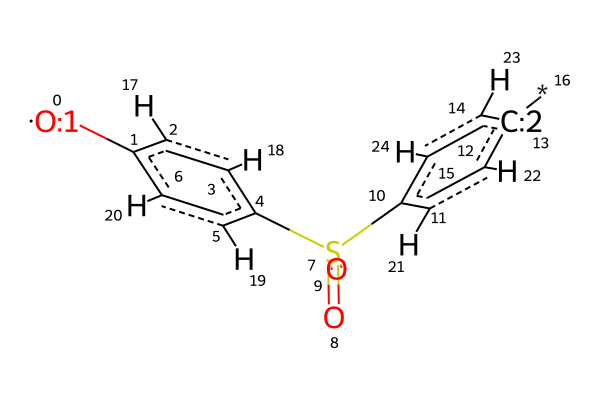

mid


[21:11:10] UFFTYPER: Unrecognized atom type: *_ (0)
[21:11:10] UFFTYPER: Unrecognized atom type: *_ (17)


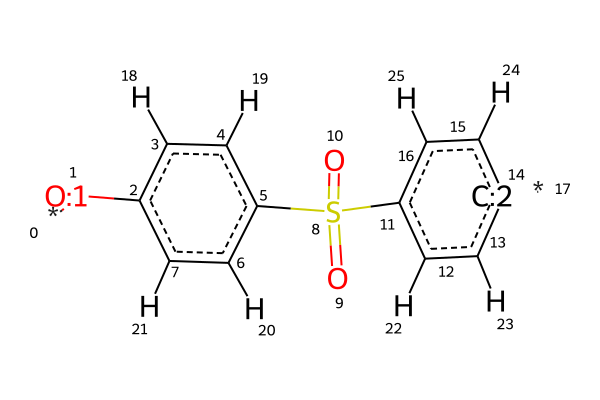

tail


[21:11:10] UFFTYPER: Unrecognized atom type: *_ (0)


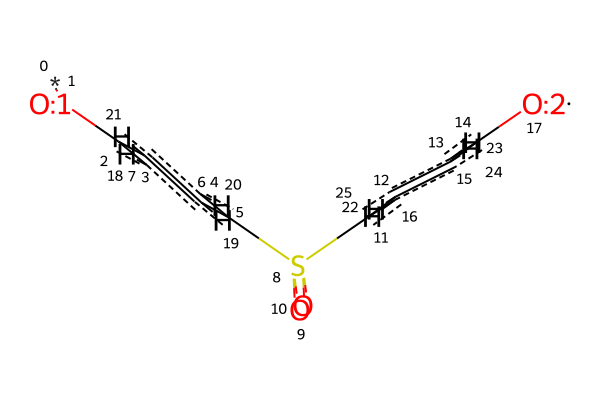

In [4]:
from mupt.mupr.primitives import Primitive
from mupt.geometry.shapes import PointCloud, Ellipsoid
from mupt.interfaces.rdkit import primitive_from_rdkit


rep_unit_smiles : dict[str, str] = {
    'head' : f'[O:{POS_1_IDX}]c1ccc(cc1)S(=O)(=O)c1cc[c:{POS_2_IDX}](cc1)-*',
    'mid'  : f'*-[O:{POS_1_IDX}]c1ccc(cc1)S(=O)(=O)c1cc[c:{POS_2_IDX}](cc1)-*',
    'tail' : f'*-[O:{POS_1_IDX}]c1ccc(cc1)S(=O)(=O)c1ccc(cc1)[O:{POS_2_IDX}]',
}
CHAIN_LINK_ORIENT : tuple[str, str] = ('A', 'B') # NOTE: literally doesn't matter what these are, as long as they're distinct and hashable
rep_unit_connection_tags : dict[str, tuple[tuple[str, str], ...]] = {
    'head' : [CHAIN_LINK_ORIENT],
    'mid'  : [CHAIN_LINK_ORIENT[::-1], CHAIN_LINK_ORIENT],
    'tail' : [CHAIN_LINK_ORIENT[::-1]],
}

lexicon : dict[str, Primitive] = {}
for unit_name, smiles in rep_unit_smiles.items():
    mol, conf_id, semimajor = mol_aligned_to_axis(smiles, axis=AXIS)
    semiminor = SEMIMINOR_FRACT * semimajor
    print(unit_name)
    display(mol)

    prim = primitive_from_rdkit(mol, conformer_idx=conf_id, label=unit_name)
    for chain_tags, connector in zip(rep_unit_connection_tags[unit_name], prim.connectors.values(), strict=True):
        connector.anchor = chain_tags[0]
        connector.linkables = {chain_tags[1]}

    radii = np.full(3, semiminor)
    radii[AXIS.value] = semimajor
    prim.shape = Ellipsoid(radii)

    lexicon[unit_name] = prim

## Construct Primitive representing homopolymer chain of given length
All units in reference position (i.e. level and centered at origin) for the moment

INFO:root:Building chain 201-mer chain (1/1)
INFO:mupt.mupr.embedding:Paired up 3 new edges after 1 iteration(s); 197/200 edges remain unpaired
INFO:mupt.mupr.embedding:Paired up 3 new edges after 2 iteration(s); 194/200 edges remain unpaired
INFO:mupt.mupr.embedding:Paired up 3 new edges after 3 iteration(s); 191/200 edges remain unpaired
INFO:mupt.mupr.embedding:Paired up 5 new edges after 4 iteration(s); 186/200 edges remain unpaired
INFO:mupt.mupr.embedding:Paired up 4 new edges after 5 iteration(s); 182/200 edges remain unpaired
INFO:mupt.mupr.embedding:Paired up 4 new edges after 6 iteration(s); 178/200 edges remain unpaired
INFO:mupt.mupr.embedding:Paired up 4 new edges after 7 iteration(s); 174/200 edges remain unpaired
INFO:mupt.mupr.embedding:Paired up 5 new edges after 8 iteration(s); 169/200 edges remain unpaired
INFO:mupt.mupr.embedding:Paired up 4 new edges after 9 iteration(s); 165/200 edges remain unpaired
INFO:mupt.mupr.embedding:Paired up 3 new edges after 10 iteratio

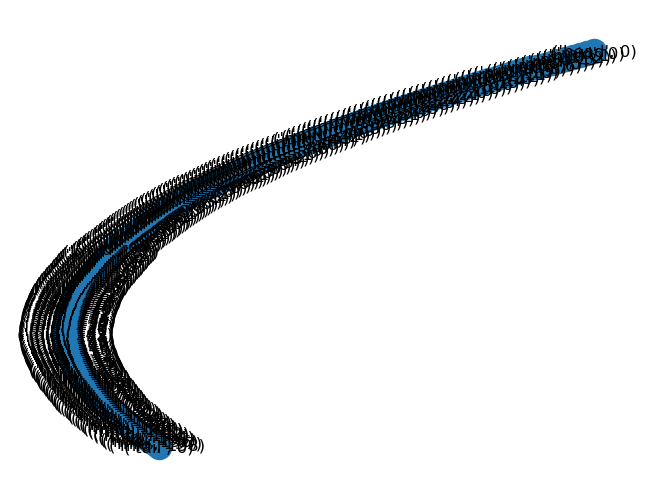

In [5]:
import networkx as nx
from mupt.mupr.topology import TopologicalStructure, noodle_graph

from mupt.builders.random_walk import AngleConstrainedRandomWalk
from mupt.geometry.coordinates import origin
from mupt.geometry.coordinates.directions import random_unit_vector


R_excl : float = 20.0
dop_min : int = 200 # must be at least 2!
dop_max : int = 201
n_chains : int = 1
univprim = Primitive(label='universe')

for i, chain_len in enumerate(np.random.randint(dop_min, dop_max + 1, size=n_chains), start=1):
    logging.info(f'Building chain {chain_len}-mer chain ({i}/{n_chains})')
    
    # build chain hierarchy
    molprim = Primitive(label='polymer_chain')
    unit_names : list[str] = ['head'] + ['mid']*(chain_len - 2) + ['tail']
    for i, unit_name in enumerate(unit_names)   :
        rep_unit_prim = lexicon[unit_name].copy()
        molprim.attach_child(rep_unit_prim)
    molprim.topology = nx.path_graph(molprim.children_by_handle.keys(), create_using=TopologicalStructure)
    
    # place beads by randow walk (other build implementations would go here)
    direction = random_unit_vector()
    builder = AngleConstrainedRandomWalk(
        angle_max_rad=np.pi/4,
        initial_point=R_excl*direction, # this is also the default, but just illustrates that you can start the walk anywhere
        initial_direction=direction,  # randomize (also default)
    )
    for handle, placement in builder.generate_placements(molprim):
        molprim.children_by_handle[handle].rigidly_transform(placement)
        
    # attach chain to universe, expand to show topology of beads
    mol_handle = univprim.attach_child(molprim)
    univprim.expand(mol_handle)

univprim.topology.visualize()

## Generate and apply centers + orientations for each repeat unit
Produced here from freely-jointed chain (stand-in for DPD, self-avoiding RW, whatever)  
Encapsulate both center and orient as a single rigid transformation

In [ ]:
# from mupt.builders.random_walk import AngleConstrainedRandomWalk
# from mupt.geometry.coordinates import origin
# from mupt.geometry.coordinates.directions import random_unit_vector


# # implementation of this builder works just as well when applied to the root of the hierarchy, provided you're satisfied with identical random walk parameters
# # this is just an example builder; other implementations would be invoked similarly
# builder = AngleConstrainedRandomWalk(
#     angle_max_rad=np.pi/4,
#     initial_point=origin(3), # this is also the default, but just illustrates that you can start the walk anywhere
#     initial_direction=None,  # randomize (also default)
# )
# for handle, placement in builder.generate_placements(univprim):
#     univprim.children_by_handle[handle].rigidly_transform(placement)

## Visualize placement of subprimitives
"Drop down" to lower co-levels in hierarchy and plot residues (as Ellipsoids here) and individual atoms (as single points)

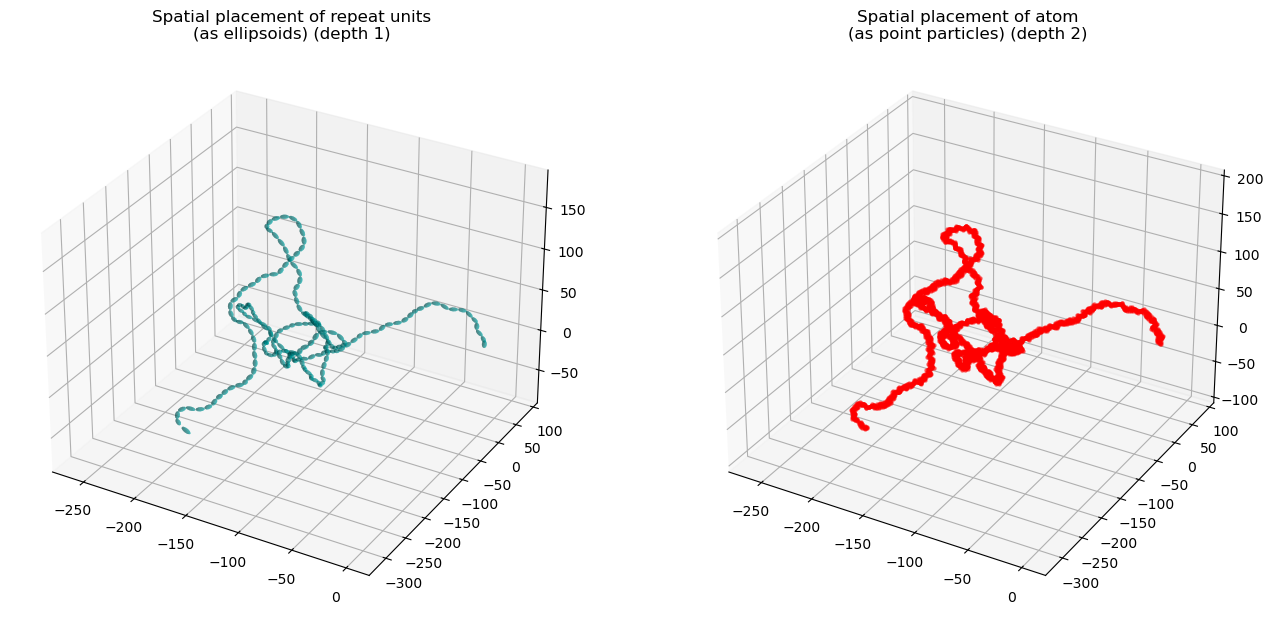

In [6]:
# NBVAL_SKIP
from anytree.iterators import LevelOrderGroupIter

import matplotlib.pyplot as plt
# %matplotlib ipympl

scale : float=16
aspect : float = 1/2
plt.close()
fig = plt.figure(figsize=(scale, scale*aspect))
fig.canvas.header_visible = False

levels : dict[int, tuple[Primitive]] = {i : grp for i, grp in enumerate(LevelOrderGroupIter(univprim))}

ellip_depth : int = 1
ax_ellip = fig.add_subplot(1, 2, ellip_depth, projection='3d')
ax_ellip.autoscale(enable=True)
ax_ellip.set_title(f'Spatial placement of repeat units\n(as ellipsoids) (depth {ellip_depth})')
for res_prim in levels[ellip_depth]:
    _ = ax_ellip.plot_surface(*res_prim.shape.surface_mesh(10, 10).T, color='c', alpha=0.5)

atom_depth : int = 2
ax_atomic = fig.add_subplot(1, 2, atom_depth, projection='3d')
ax_atomic.autoscale(enable=True)
ax_atomic.set_title(f'Spatial placement of atom\n(as point particles) (depth {atom_depth})')
for res_prim in levels[atom_depth]:
    _ = ax_atomic.scatter(*res_prim.shape.positions.T, color='r', marker='.', alpha=0.5)

In [7]:
# # optional; can apply a rigid transformation to the ENTIRE molecule at once - 
# random_rot = RigidTransform.from_rotation(Rotation.random())
# univprim.rigidly_transform(random_rot)

## Flatten Primitive hierarchy and export as all-atom system
Expand each level until the hierarchy is just leaves below a root (atoms in a molecule system), then write out to RDKit

In [8]:
from rdkit.Chem import MolToMolFile
from mupt.interfaces.rdkit import primitive_to_rdkit


save_path : str = 'ellipsoidal_PPS_chain.mol'
chain : Mol = primitive_to_rdkit(univprim)

print(f'Exporting {chain.GetNumAtoms()}-atom system to {save_path}')
MolToMolFile(chain, save_path)

Exporting 4825-atom system to ellipsoidal_PPS_chain.mol
